In [2]:
# ================================
# 1. Install and Import Libraries
# ================================
# !pip install tweepy nltk pandas matplotlib wordcloud plotly dash dash-bootstrap-components python-dotenv vaderSentiment
import os
import re
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import tweepy
from dotenv import load_dotenv
import dash
from dash import dcc, html, dash_table, Input, Output
import dash_bootstrap_components as dbc
import plotly.express as px

# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get NLTK stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jessiereddjr./nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessiereddjr./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
pip install dotenv

You should consider upgrading via the '/Users/jessiereddjr./opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# ================================
# 2. Load Environment Variables
# ================================
# .env file should have:
# TWITTER_CONSUMER_KEY=your_key
# TWITTER_CONSUMER_SECRET=your_secret
# TWITTER_ACCESS_TOKEN=your_token
# TWITTER_ACCESS_SECRET=your_token_secret

load_dotenv()

consumer_key = os.environ.get("TWITTER_CONSUMER_KEY")
consumer_secret = os.environ.get("TWITTER_CONSUMER_SECRET")
access_token = os.environ.get("TWITTER_ACCESS_TOKEN")
access_token_secret = os.environ.get("TWITTER_ACCESS_SECRET")
bearer_token = os.environ.get("TWITTER_BEARER_TOKEN")

# ================================
# 3. Connect to Twitter API v2
# ================================
client = tweepy.Client(
    bearer_token=os.environ["TWITTER_BEARER_TOKEN"],
    wait_on_rate_limit=True
)
# ================================
# 4. Collect Tweets
# ================================
query = (
    '(housing OR dorm OR residence OR "student housing" OR "dorm shortage" OR roommate OR "off campus" OR "no housing") '
    '(UNC OR "UNC Chapel Hill" OR #UNCC OR #uncc OR "UNC Charlotte" OR #NCSU OR #ncsu OR "NC State" OR "North Carolina Central" OR #NCCU OR #nccu OR "App State") '
    '-is:retweet lang:en'
)
response = client.search_recent_tweets(
    query=query,
    max_results=35,
    tweet_fields=["created_at", "text", "author_id"]
)

data = []
if response.data:
    for tweet in response.data:
        data.append(tweet.text)
else:
    print("No tweets found for this query.")

df = pd.DataFrame(data, columns=["tweet"])

# ================================
# 5. Preprocess Tweets (with Stop Word Removal)
# ================================
def clean_tweet(text):
    # Remove links, mentions, hashtags (symbol only), punctuation and numbers
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    # Convert to lower case and strip white space
    text = text.lower().strip()
    # Tokenize and remove stop words
    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words]
    return " ".join(cleaned_words)

df["clean_tweet"] = df["tweet"].apply(clean_tweet)

Top words:
          word  count
0         unc      7
1     housing      5
2          im      3
3    roommate      2
4      theyre      2
5         ive      2
6    carolina      2
7        made      2
8     stadium      2
9   community      2
10    student      2
11      years      2
12     philly      2
13      youre      2
14     campus      2


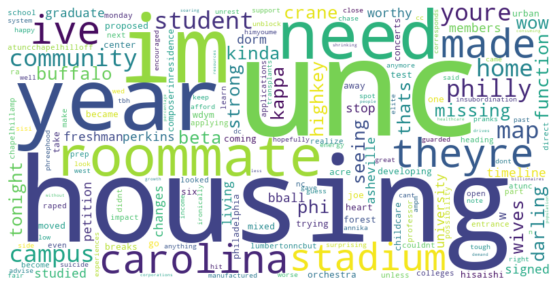

In [5]:
# ================================
# 6. Bag of Words Analysis and Word Cloud
# ================================
all_words = " ".join(df["clean_tweet"]).split()
word_freq = Counter(all_words)
common_words = pd.DataFrame(word_freq.most_common(15), columns=["word", "count"])
print("Top words:\n", common_words)

# Generate Word Cloud Visualization
wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [6]:
# ================================
# 7. Sentiment Analysis (VADER)
# ================================
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
df["sentiment"] = df["clean_tweet"].apply(lambda x: sia.polarity_scores(x)["compound"])
df["label"] = df["sentiment"].apply(
    lambda x: "positive" if x > 0.05 else ("negative" if x < -0.05 else "neutral")
)

In [7]:
# ================================
# 8. Thematic Coding
# ================================
# Expanded themes based on student sentiments regarding campus housing:
themes = {
    "Housing Frustration": [
        "shortage", "waitlist", "overcrowded", "problem",
        "struggling", "frustrated", "cramped", "expensive"
    ],
    "Quality Amenities": [
        "modern", "comfortable", "wellmaintained", "clean",
        "quality", "updated", "nice"
    ],
    "Community Support": [
        "roommate", "friend", "community", "together",
        "support", "shared", "social"
    ],
    "Effective Administration": [
        "responsive", "helpful", "administration", "policy",
        "service", "quick", "administrative"
    ],
    "Facilities Issues": [
        "dorm", "maintenance", "broken", "building",
        "infrastructure", "facilities", "old"
    ]
}

def assign_theme(tweet):
    tweet_lower = tweet.lower()
    # Collect all matching themes; a tweet might touch on multiple themes.
    matched_themes = []
    for theme, keywords in themes.items():
        for kw in keywords:
            if kw in tweet_lower:
                matched_themes.append(theme)
                break  # Stop checking further keywords for this theme after a match.
    if not matched_themes:
        return "Other"
    # Join multiple themes using a comma.
    return ", ".join(matched_themes)

df["theme"] = df["clean_tweet"].apply(assign_theme)

In [8]:
# ================================
# 9. Summarize Data
# ================================
theme_summary = (
    df.groupby(["theme", "label"])
    .size()
    .reset_index(name="count")
)
theme_summary["percent"] = theme_summary.groupby("theme")["count"].apply(
    lambda x: (x / x.sum()) * 100
)
print(theme_summary)

# ================================
# 10. Dashboard with Dash
# ================================
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.FLATLY])

# Create figures using Plotly Express
overall_fig = px.pie(
    df, names="label", title="Overall Sentiment of NCCU Housing Tweets"
)
theme_fig = px.bar(
    theme_summary,
    x="theme",
    y="percent",
    color="label",
    barmode="group",
    title="Sentiment by Theme (Housing Shortage at NCCU)"
)

# Layout for the Dashboard
app.layout = dbc.Container([
    dbc.Row(
        dbc.Col(html.H2("NCCU Housing Sentiment Dashboard"), className="mb-4")
    ),
    dbc.Row([
        dbc.Col(dcc.Graph(id="overall", figure=overall_fig), md=6),
        dbc.Col(dcc.Graph(id="theme", figure=theme_fig), md=6)
    ]),
    dbc.Row(
        dbc.Col(html.H4("Sample Tweets by Theme"), className="mt-4")
    ),
    dbc.Row([
        dbc.Col(dash_table.DataTable(
            id="tweet-table",
            columns=[{"name": c, "id": c} for c in ["clean_tweet", "label", "theme"]],
            page_size=5,
            style_table={'overflowX': 'auto'},
            style_cell={'textAlign': 'left'}
        ), md=12)
    ])
])

# Interactivity: Filter tweets by clicking on a bar in the theme chart
@app.callback(
    Output("tweet-table", "data"),
    Input("theme", "clickData")
)
def display_tweets(clickData):
    if clickData:
        selected_theme = clickData["points"][0]["x"]
        return df[df["theme"] == selected_theme][["clean_tweet", "label", "theme"]].to_dict("records")
    else:
        return df[["clean_tweet", "label", "theme"]].sample(5).to_dict("records")

if __name__ == "__main__":
    app.run(debug=True)

               theme     label  count     percent
0  Community Support  negative      2   40.000000
1  Community Support   neutral      1   20.000000
2  Community Support  positive      2   40.000000
3  Facilities Issues  positive      1  100.000000
4              Other   neutral      1   16.666667
5              Other  positive      5   83.333333
